# 특수문자 제거

In [30]:
import os
import json

# 이미지에 나온 특수문자를 리스트로 정의
special_chars = [
    '.', ':', '-', ';', '*', '(', ')', '/', '%', '#', '!', '[', ']', '@', '+', '=', '&', '_', '>', '<', '$', '"', '\\', '{', '}'
]

def is_special_char(c):
    # 특수문자 리스트에 포함된 문자인지 확인
    return c in special_chars

def is_special_char_majority(transcription):
    # 특수문자가 50% 이상인지 확인
    if not transcription:
        return False
    special_count = sum(1 for c in transcription if is_special_char(c))
    return (special_count / len(transcription)) >= 0.5

def should_exclude_transcription(transcription):
    # transcription이 비어있거나 특수문자가 50% 이상인 경우 True 반환
    return not transcription or is_special_char_majority(transcription)

def process_json(input_path, output_path):
    # 기존 JSON 파일을 읽고, 빈 transcription 또는 특수문자가 50% 이상인 경우 제외한 JSON 파일 생성
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    for img_name, img_data in data["images"].items():
        words = img_data.get("words", {})
        words_filtered = {}

        # 빈 transcription인 단어 및 특수문자가 50% 이상인 단어 제거
        for word_id, word_data in words.items():
            transcription = word_data.get("transcription", "")
            if not should_exclude_transcription(transcription):
                words_filtered[word_id] = word_data
        
        # 필터링된 단어 리스트가 비어있으면 'words' 필드를 삭제
        if not words_filtered:
            img_data.pop("words", None)  # 'words' 키 삭제
        else:
            img_data["words"] = words_filtered

    # 결과 저장
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

# 언어별 영수증 폴더 안의 모든 train.json 파일 처리
data_folder = "../data/"
for lang_folder in os.listdir(data_folder):
    json_path = os.path.join(data_folder, lang_folder, "ufo", "train.json")
    output_path = os.path.join(data_folder, lang_folder, "ufo", "remove_sc_train.json")
    
    if os.path.exists(json_path):
        process_json(json_path, output_path)


# 확인

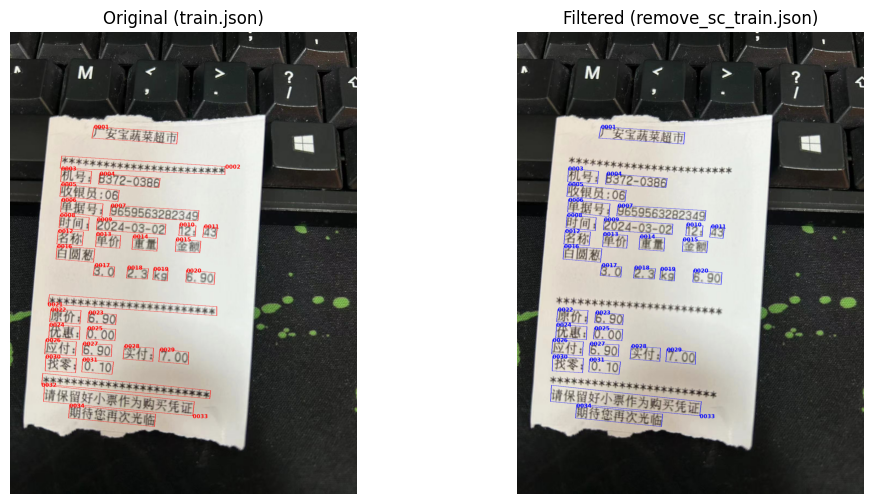

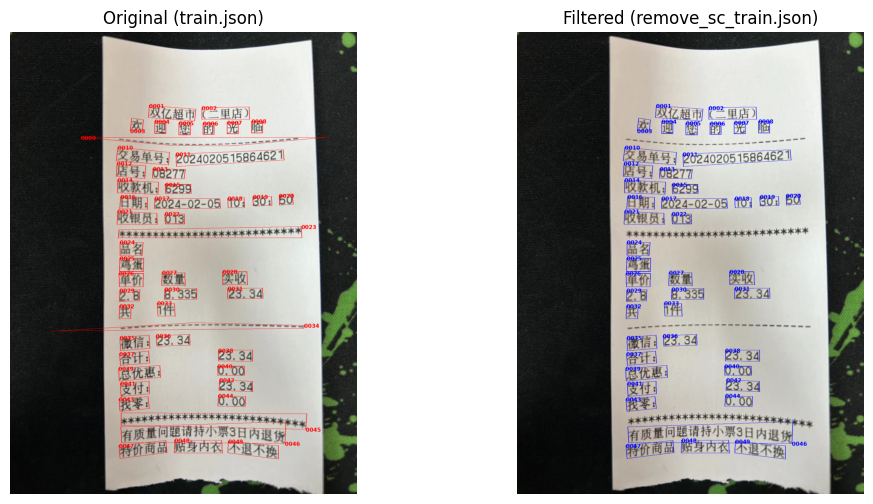

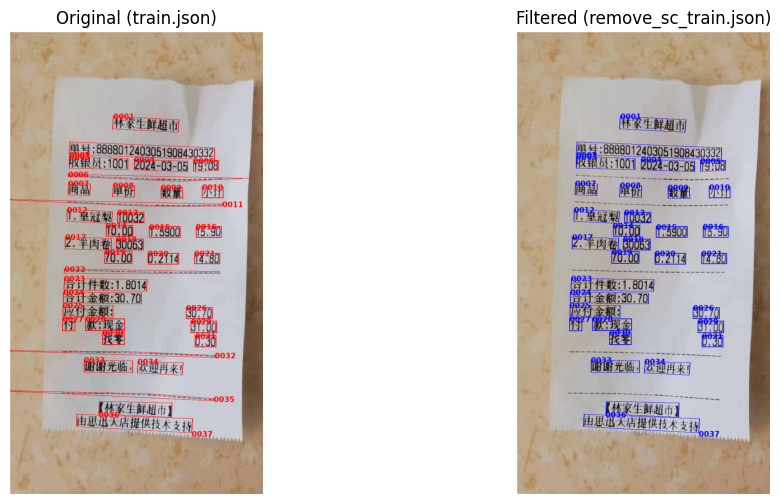

KeyboardInterrupt: 

In [3]:
import os
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def load_json(json_path):
    # JSON 파일 로드
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def draw_bounding_boxes(image_path, words_data, color):
    # 이미지 로드
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    
    # 원하는 폰트와 크기 설정 (여기서 폰트 경로를 바꿔줘야 해)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"  # 원하는 폰트 파일 경로 (자신의 시스템에 맞게 변경 필요)
    font_size = 20  # 원하는 폰트 크기
    font = ImageFont.truetype(font_path, font_size)  # 폰트 로드

    # 각 바운딩박스를 그리기
    for word_id, word in words_data.items():
        points = word['points']
        # 사각형 좌표 (4개의 꼭지점)
        bbox = [(point[0], point[1]) for point in points]
        draw.polygon(bbox, outline=color, width=2)
        
        # 바운딩 박스의 첫 번째 점 위치에 단어 번호 출력
        text_position = (points[0][0], points[0][1] - 10)  # 번호를 바운딩 박스 위에 출력
        draw.text(text_position, word_id, fill=color, font=font)

    return image

def compare_images(image_folder, json_path1, json_path2):
    # 두 JSON 파일 로드
    data1 = load_json(json_path1)
    data2 = load_json(json_path2)
    
    for img_name in data1["images"]:
        if img_name in data2["images"]:
            img_path = os.path.join(image_folder, img_name)
            if not os.path.exists(img_path):
                print(f"이미지 파일 {img_name}이 존재하지 않습니다.")
                continue
            
            # JSON에서 해당 이미지의 words 데이터 로드
            words_data1 = data1["images"][img_name]["words"]
            words_data2 = data2["images"][img_name]["words"]
            
            # 두 개의 이미지에 바운딩 박스를 그린 이미지 생성
            img1 = draw_bounding_boxes(img_path, words_data1, color="red")   # 원본 데이터 (빨간색)
            img2 = draw_bounding_boxes(img_path, words_data2, color="blue")  # 필터링된 데이터 (파란색)
            
            # 두 이미지 비교 시각화
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(img1)
            axes[0].set_title("Original (train.json)")
            axes[1].imshow(img2)
            axes[1].set_title("Filtered (remove_sc_train.json)")
            for ax in axes:
                ax.axis("off")
            plt.show()

# 이미지 폴더와 JSON 파일 경로 설정
image_folder = "../data/chinese_receipt/img/train"
json_path1 = "../data/chinese_receipt/ufo/train.json"
json_path2 = "../data/chinese_receipt/ufo/remove_sc_train.json"

# 비교 함수 실행
compare_images(image_folder, json_path1, json_path2)
